In [1]:
# check if packages can be loaded, i.e. they are already installed
library(EMCluster) # Soft CLustering
library(mvtnorm) # multi-variate normal distributions
library(ISLR2) # contains the `NCI60` data set

Loading required package: MASS

Loading required package: Matrix


Attaching package: 'ISLR2'


The following object is masked from 'package:MASS':

    Boston




2 Hierarchical Clustering

2.1 Introduction

In [2]:
# data generation
set.seed(1234567890)
x <- matrix(rnorm(50 * 2), ncol = 2)
x[1:25,1] <- x[1:25,1] + 2
x[1:25,2] <- x[1:25,2] - 2


2.2 The NCI60 data set

This is an unsupervised learning analysis of a fairly complicated genomic data set is using
PCA and hierarchical clustering. It is covered in James et al. on pages 540 to 5451.

3 Soft CLustering

3.1 EM Clustering by hand

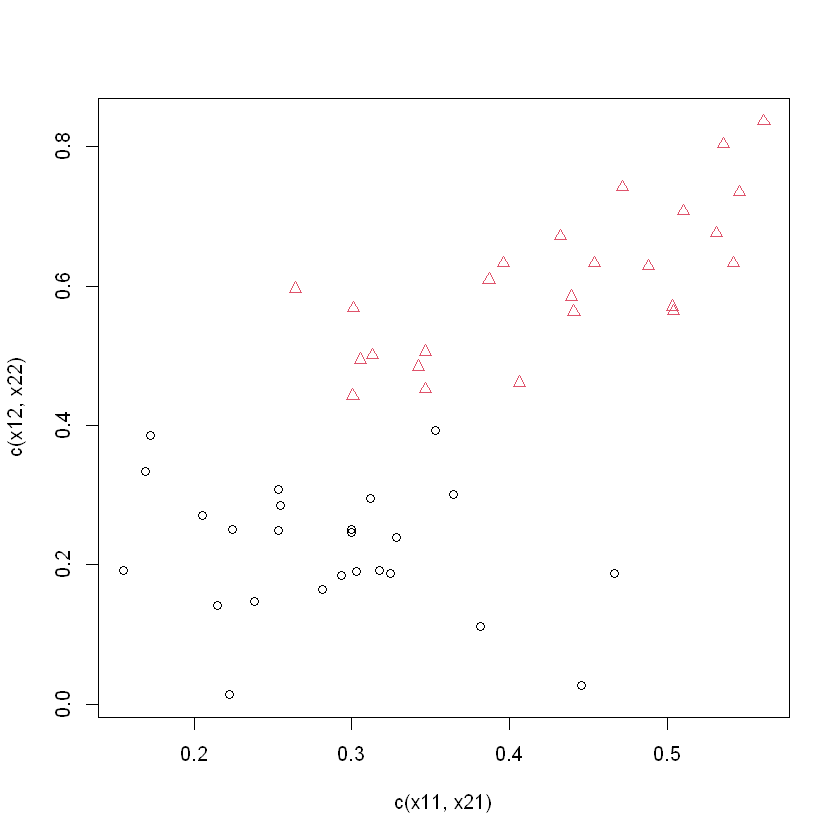

   truth
     1  2
  1  0 17
  2 25  8

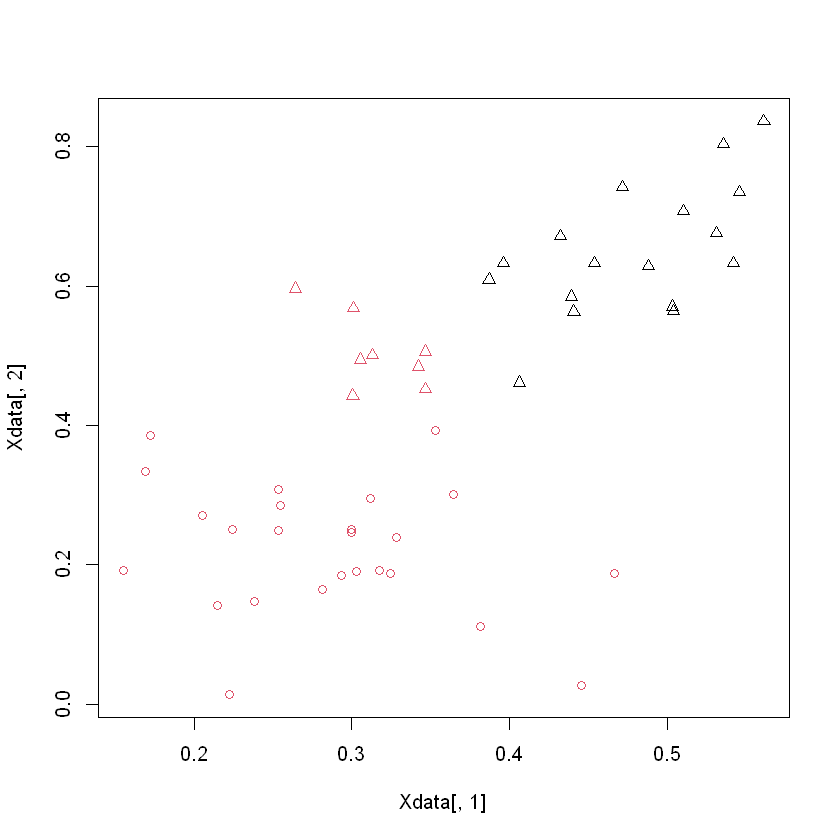

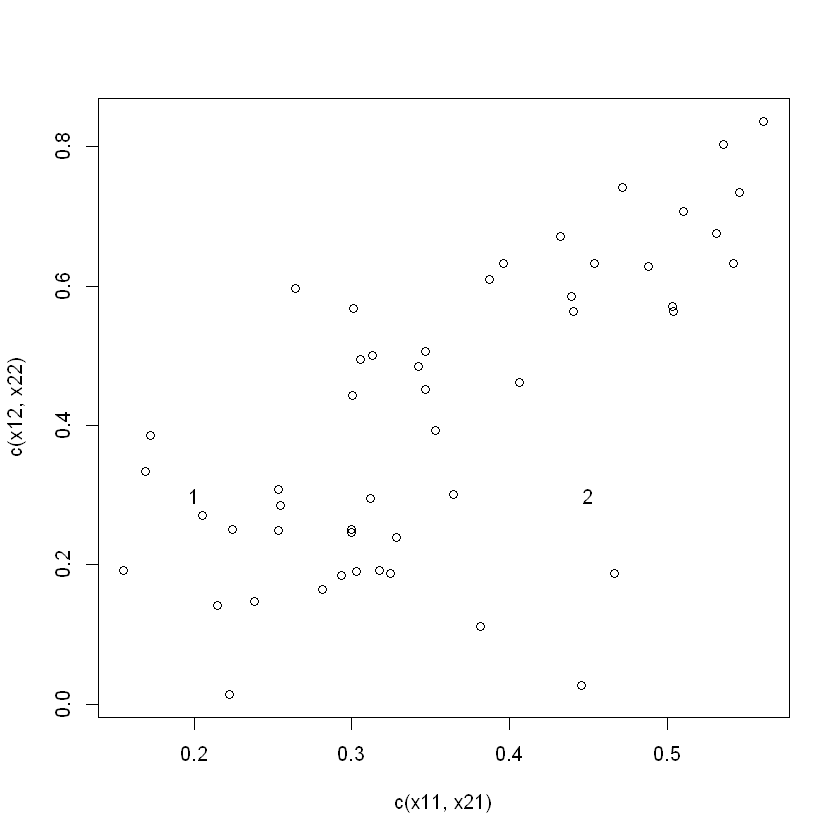

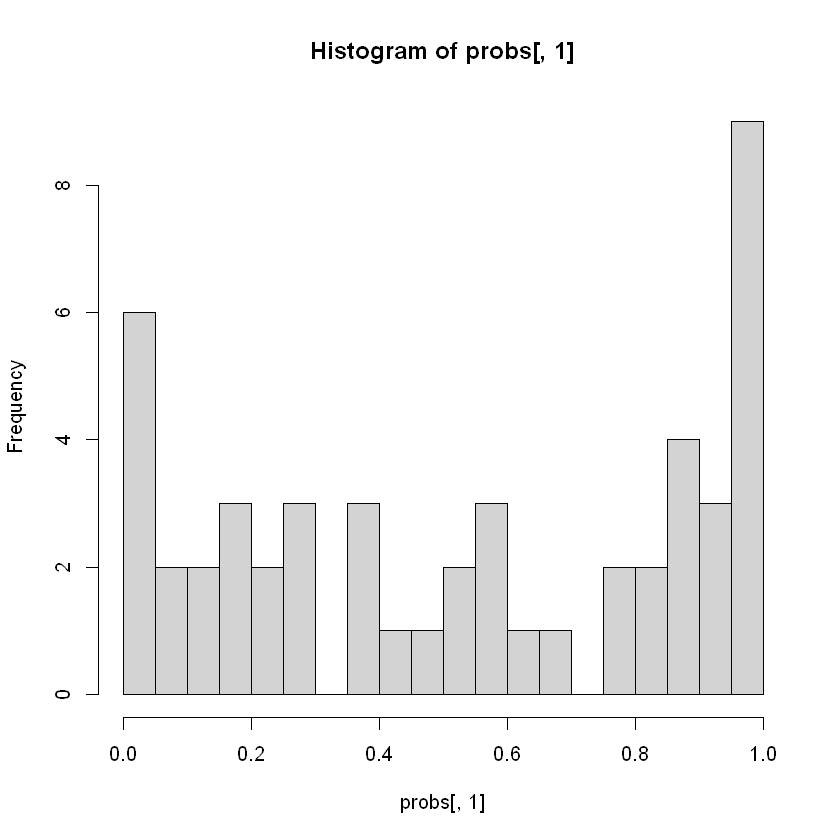

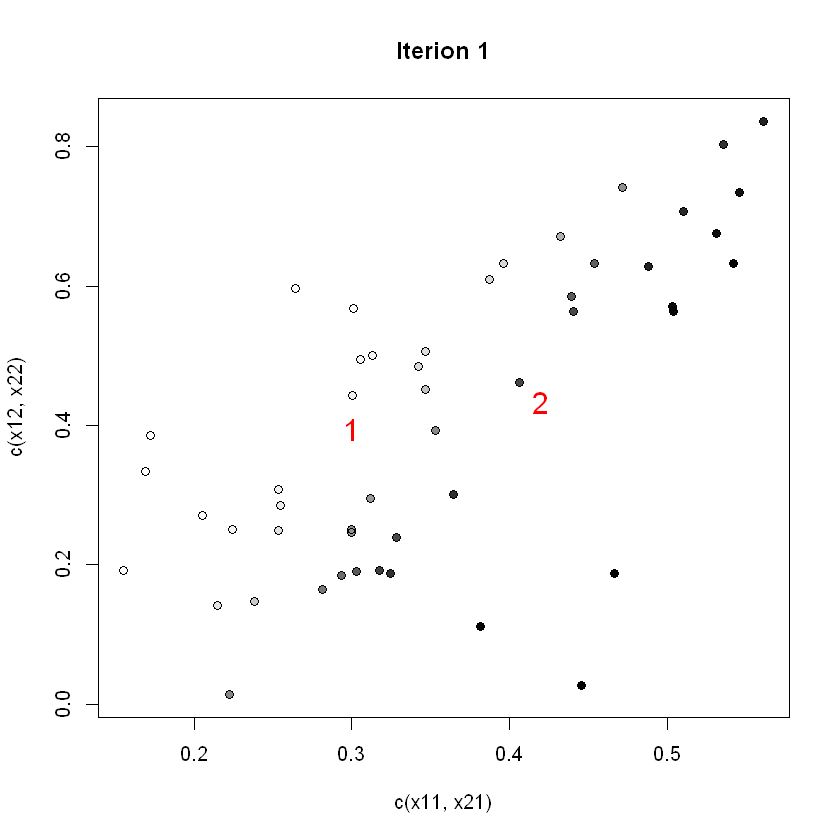

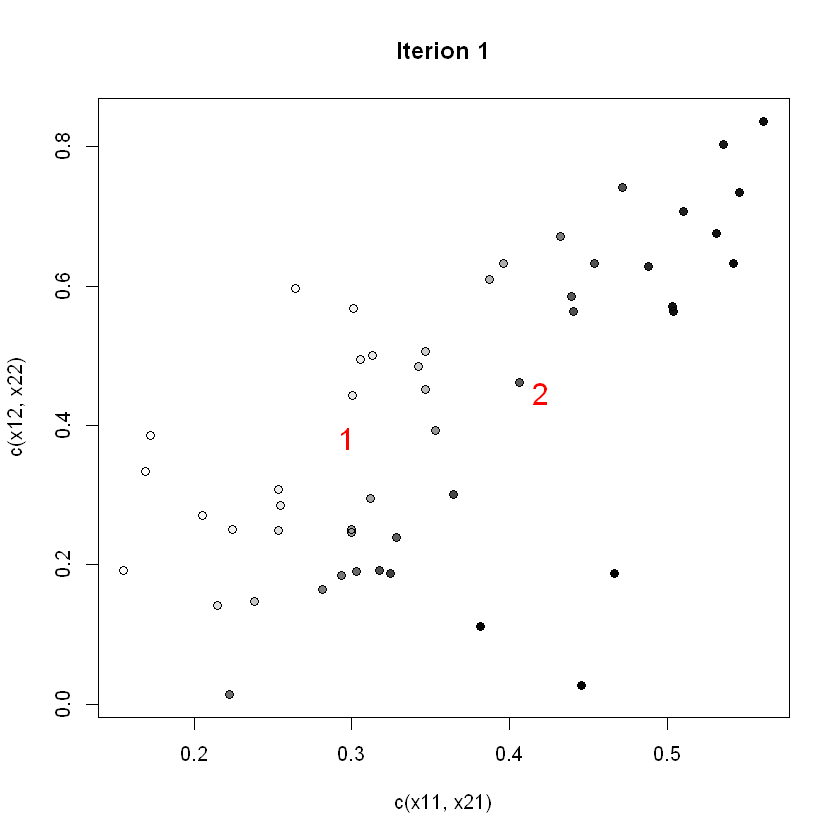

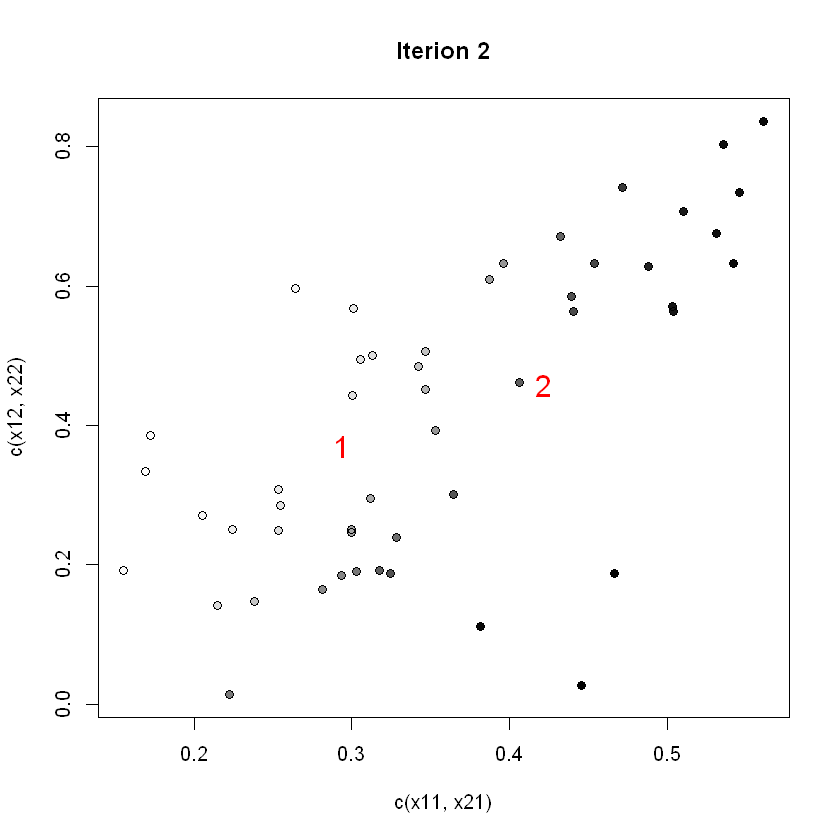

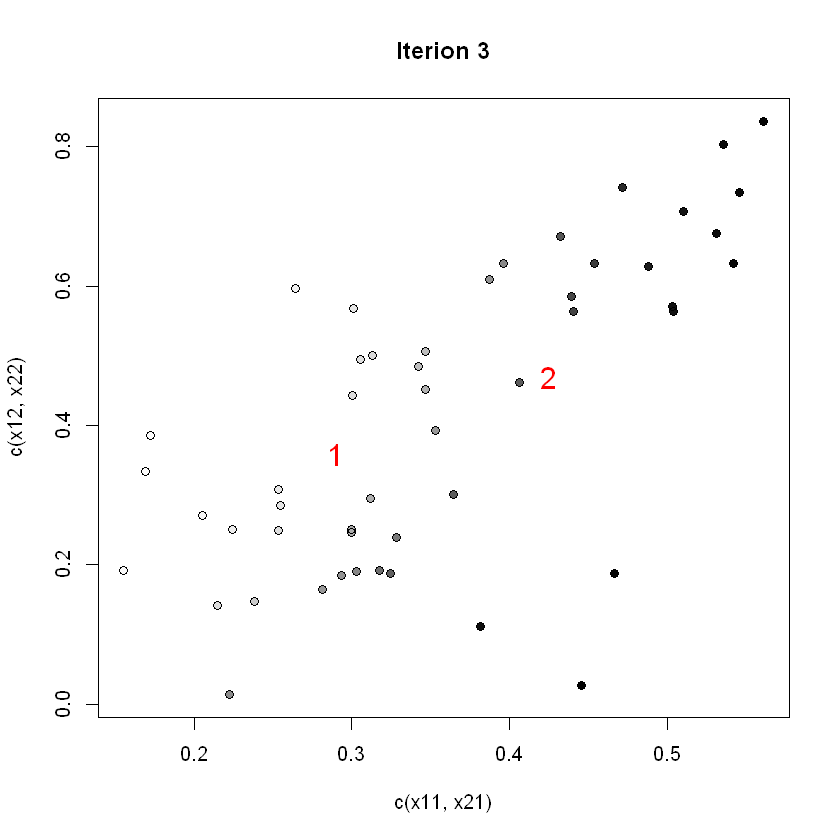

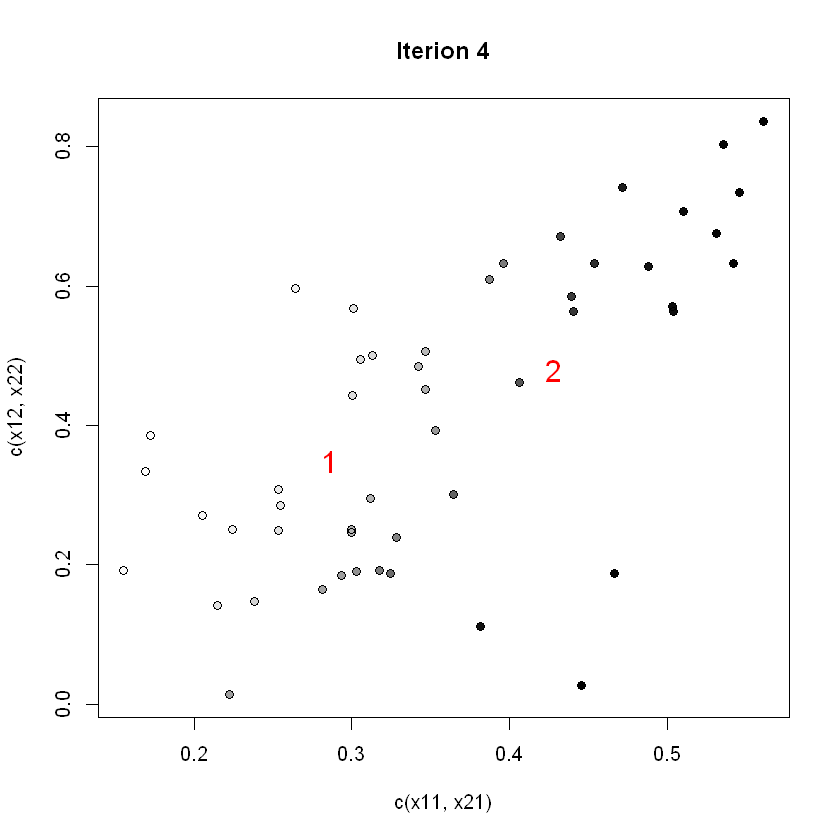

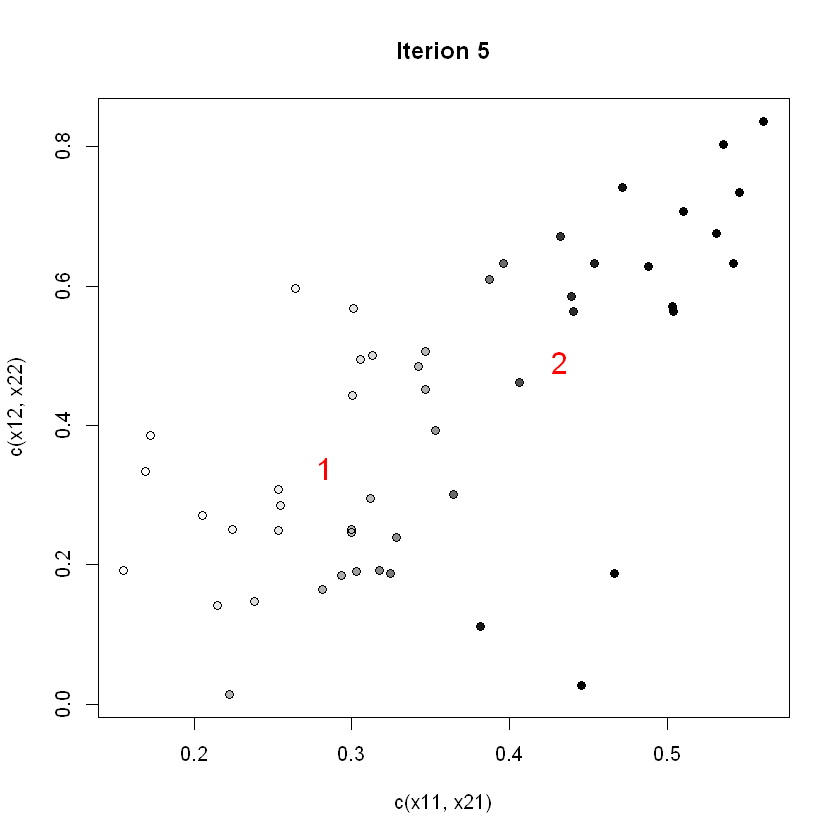

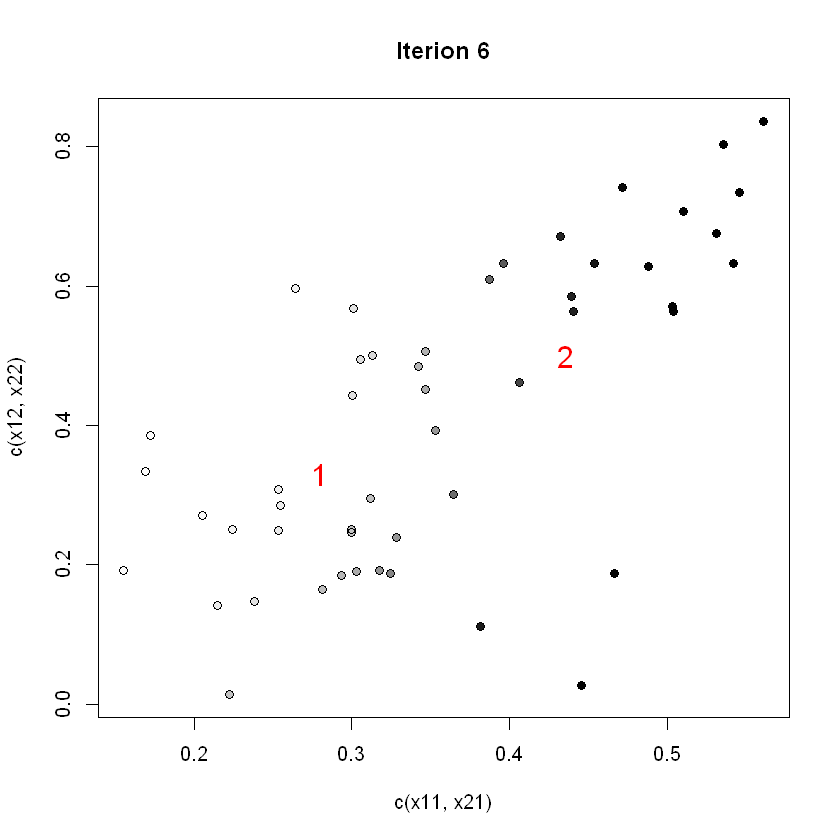

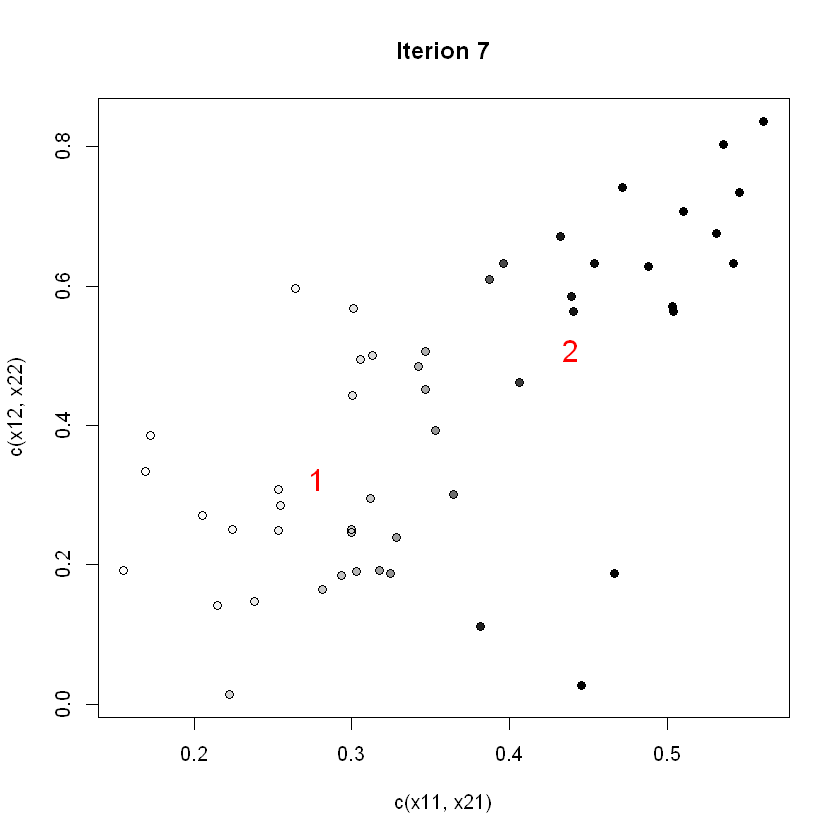

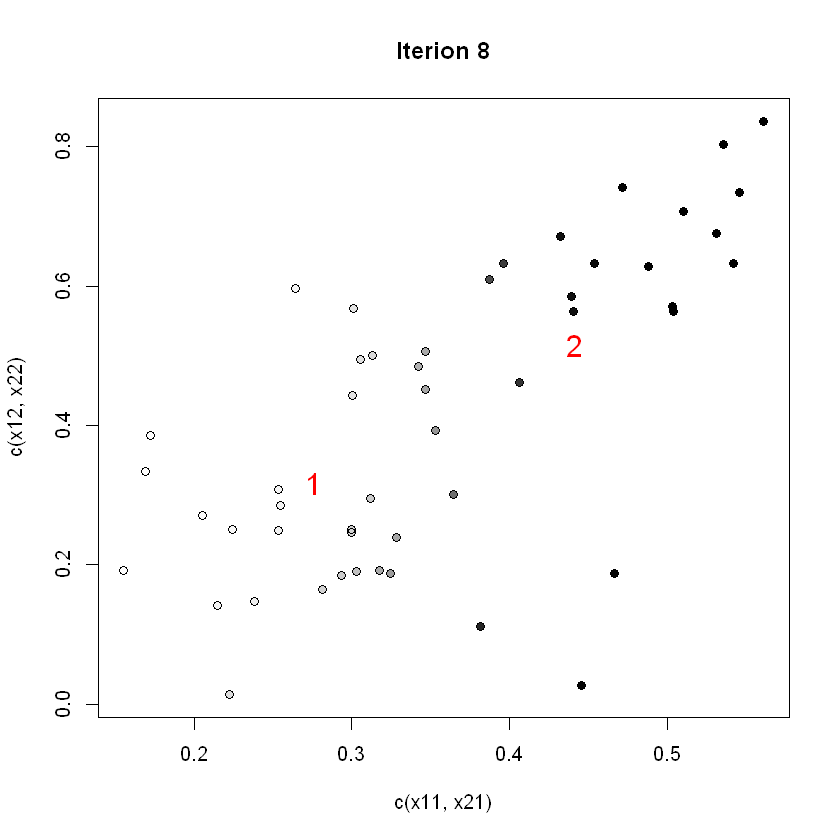

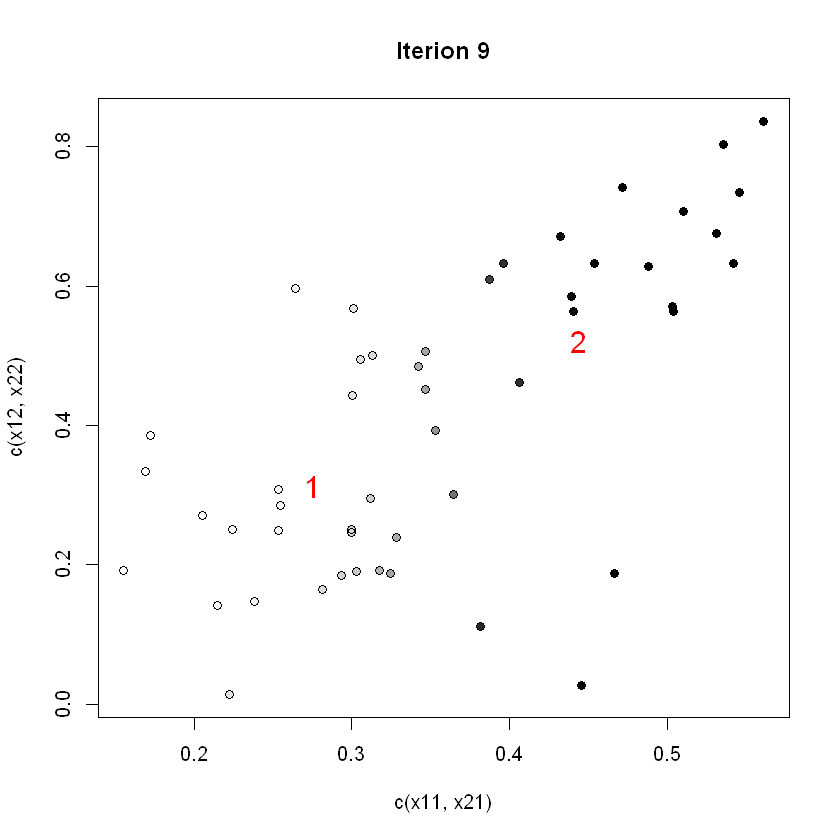

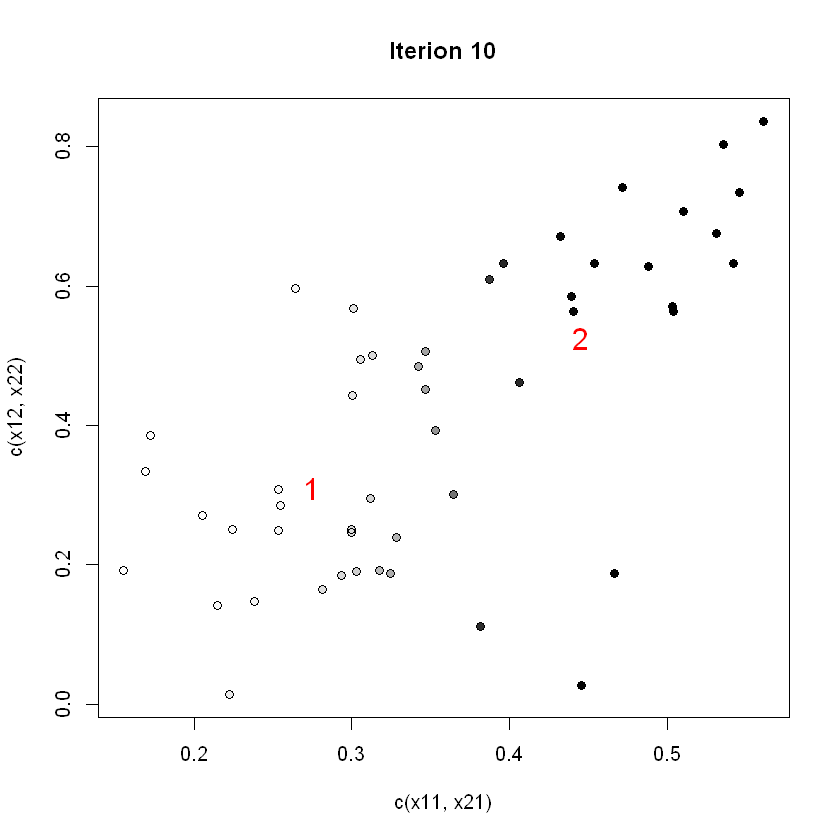

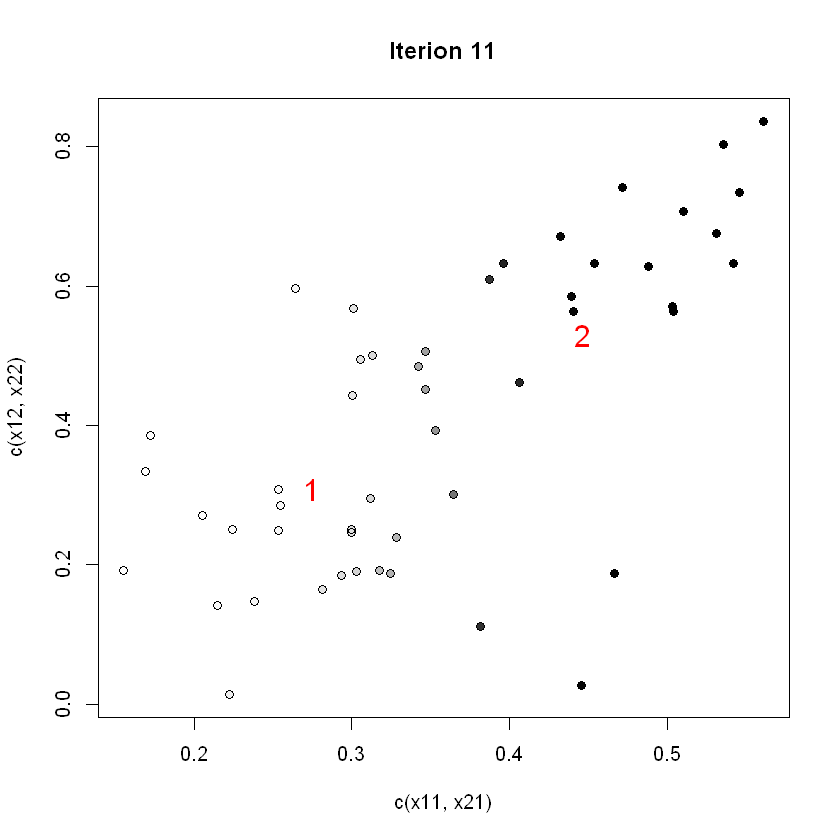

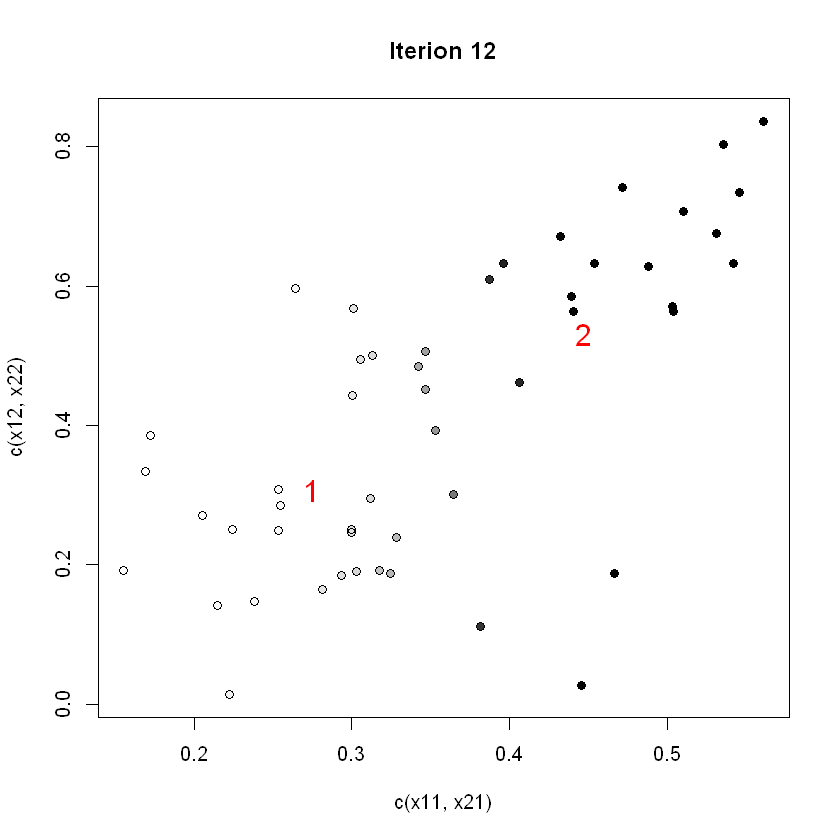

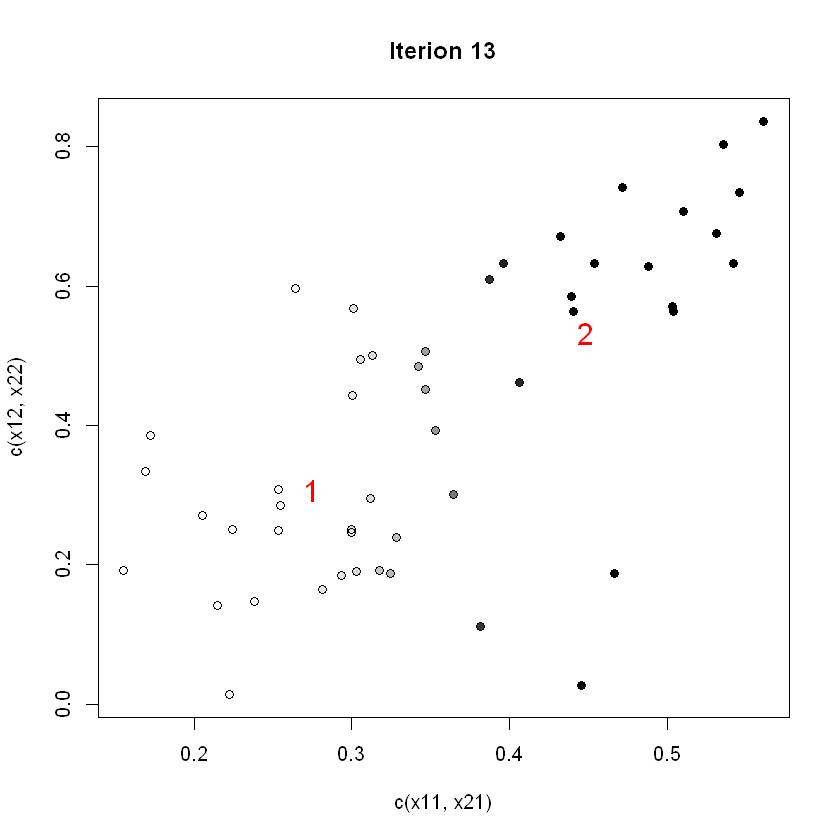

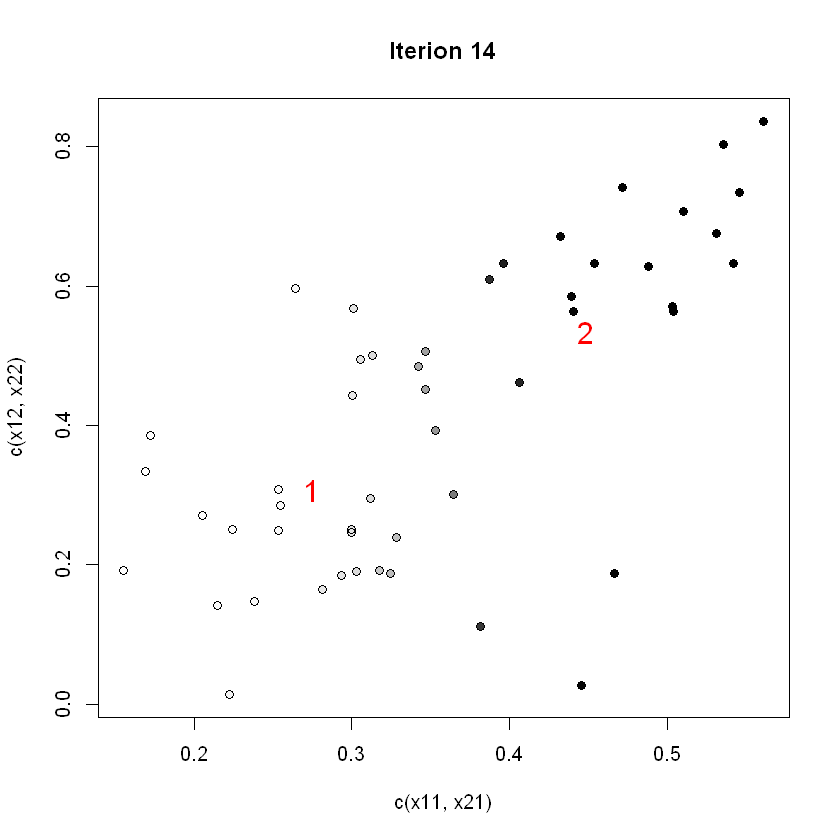

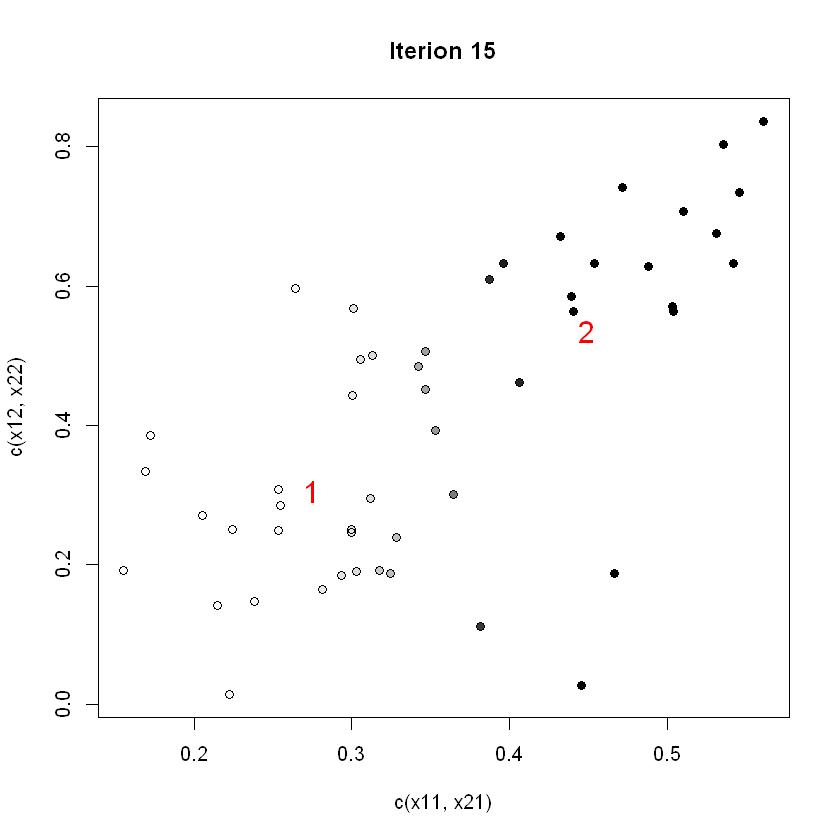

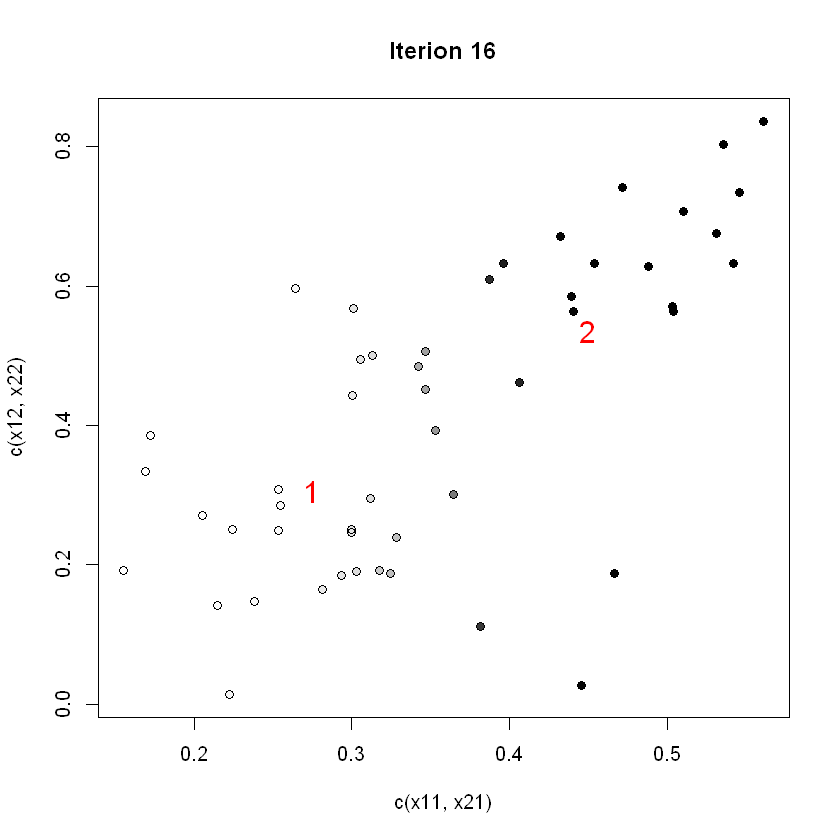

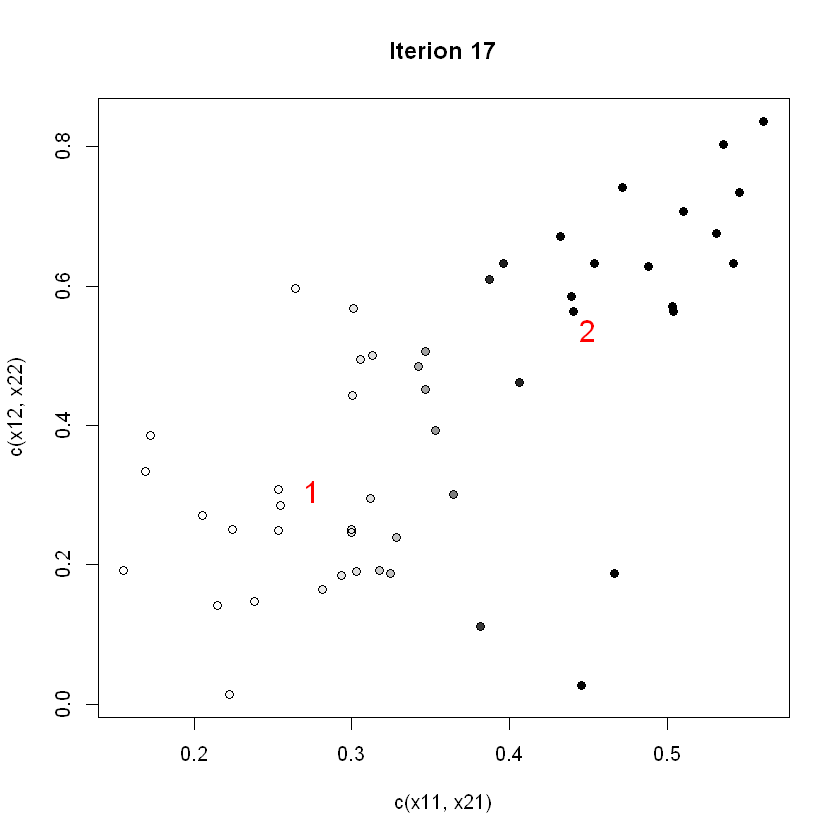

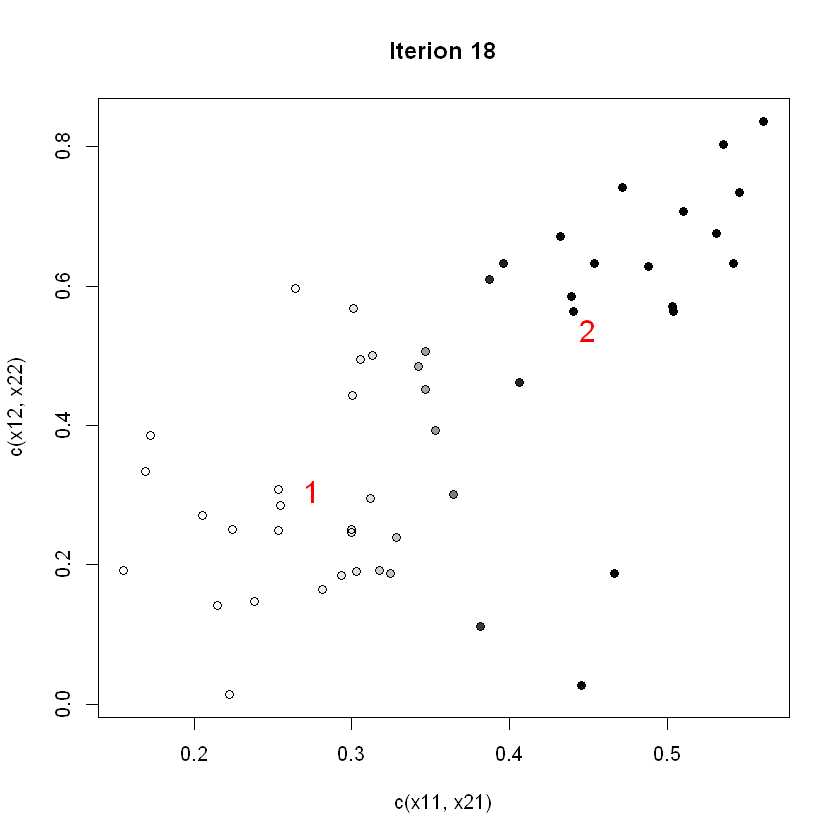

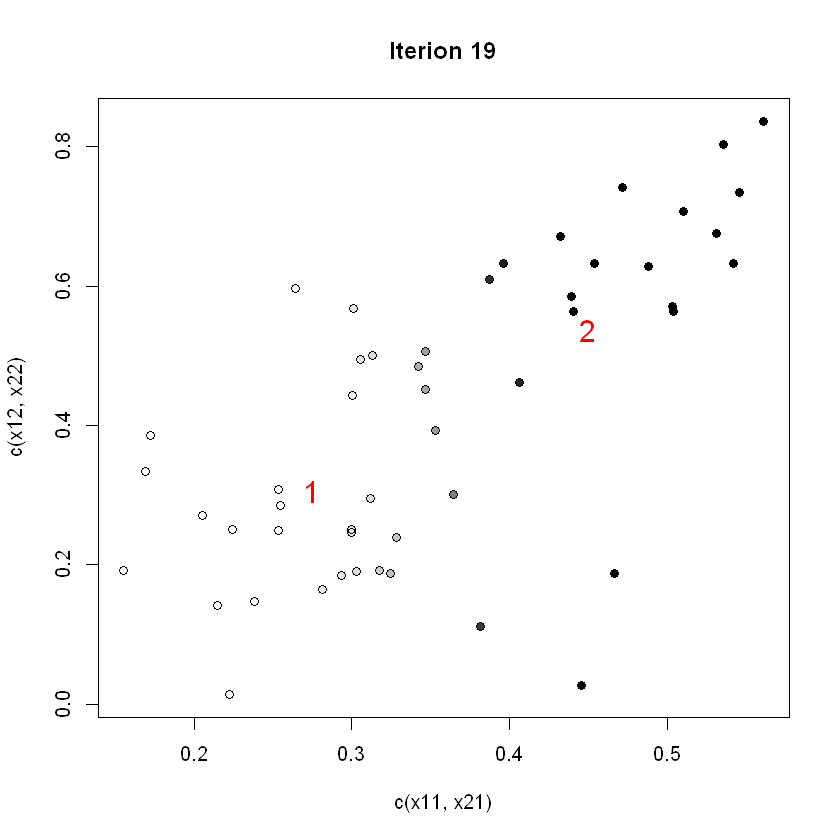

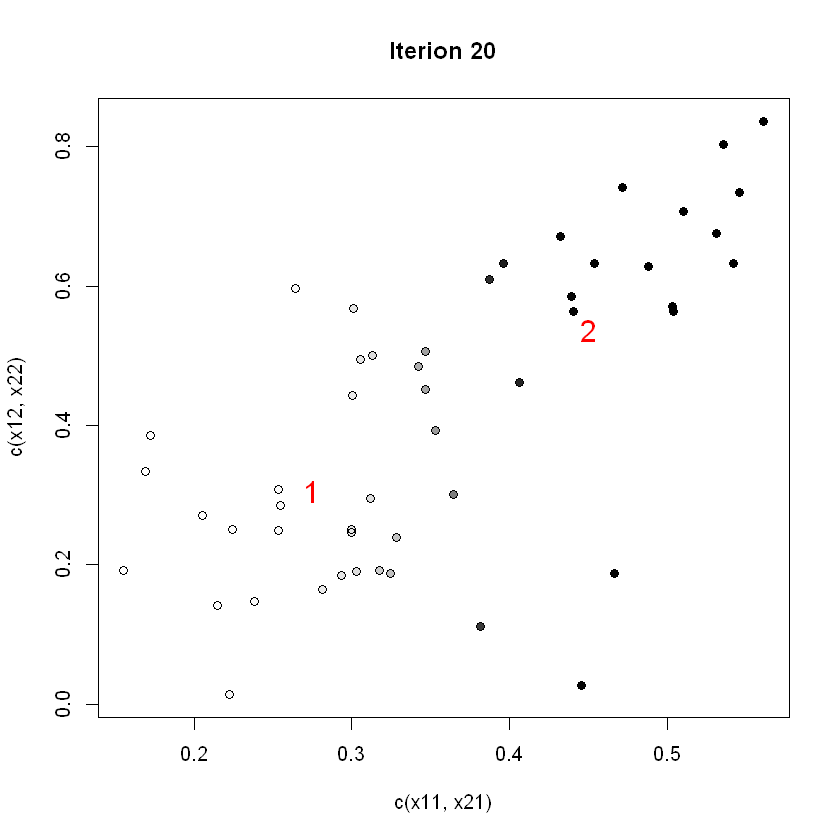

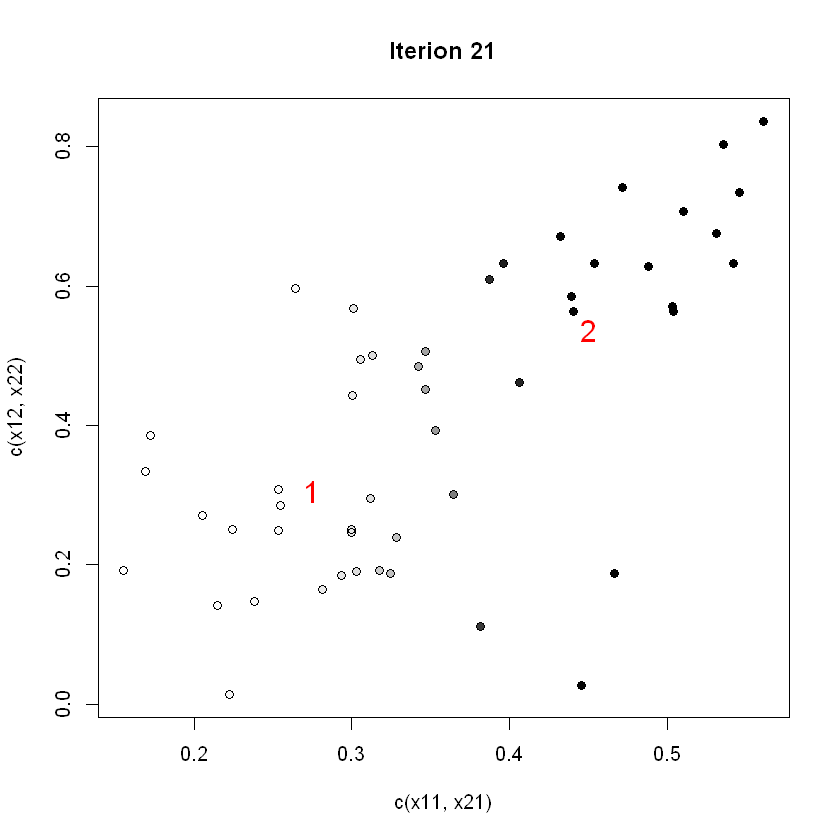

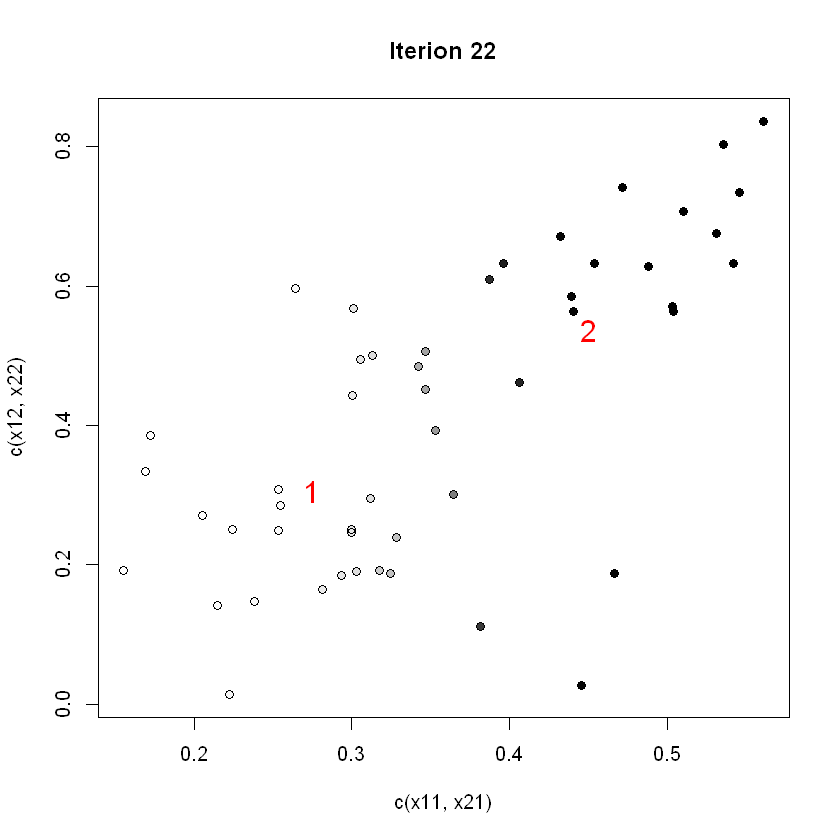

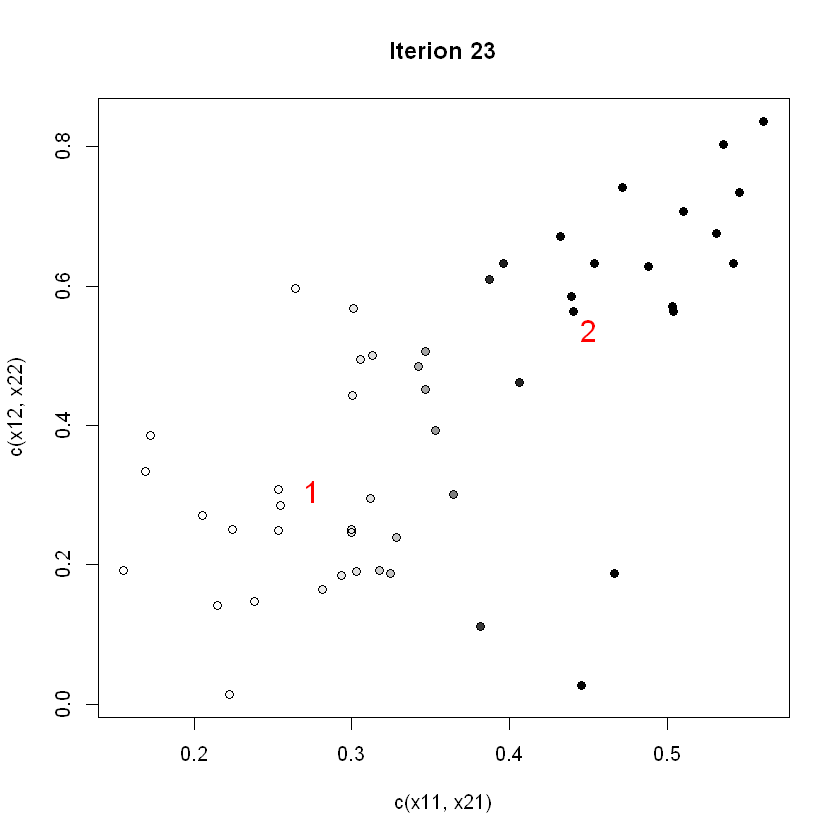

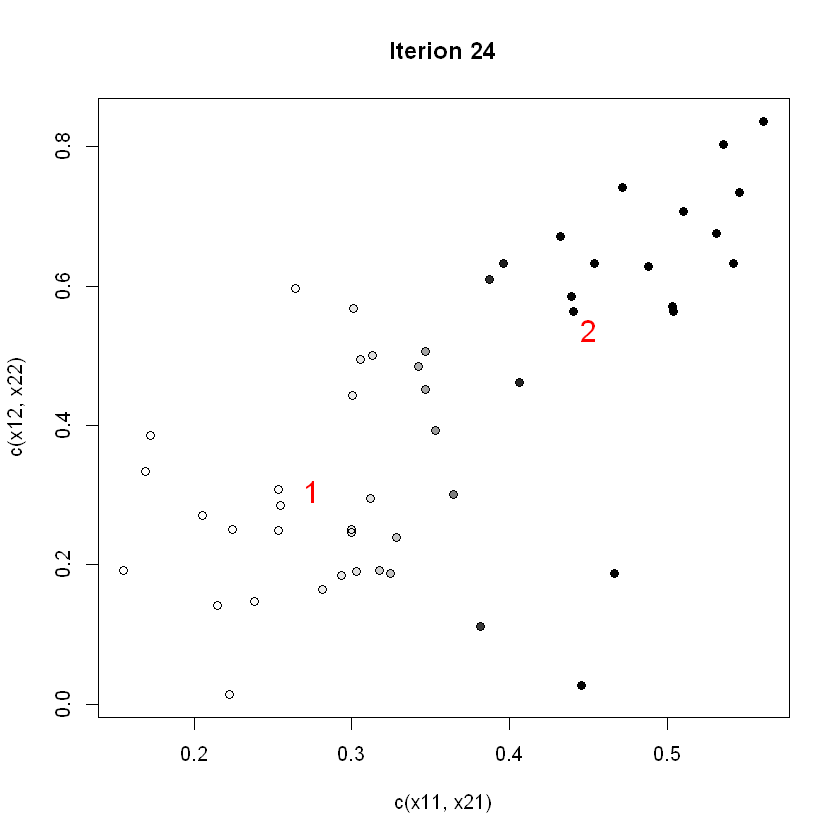

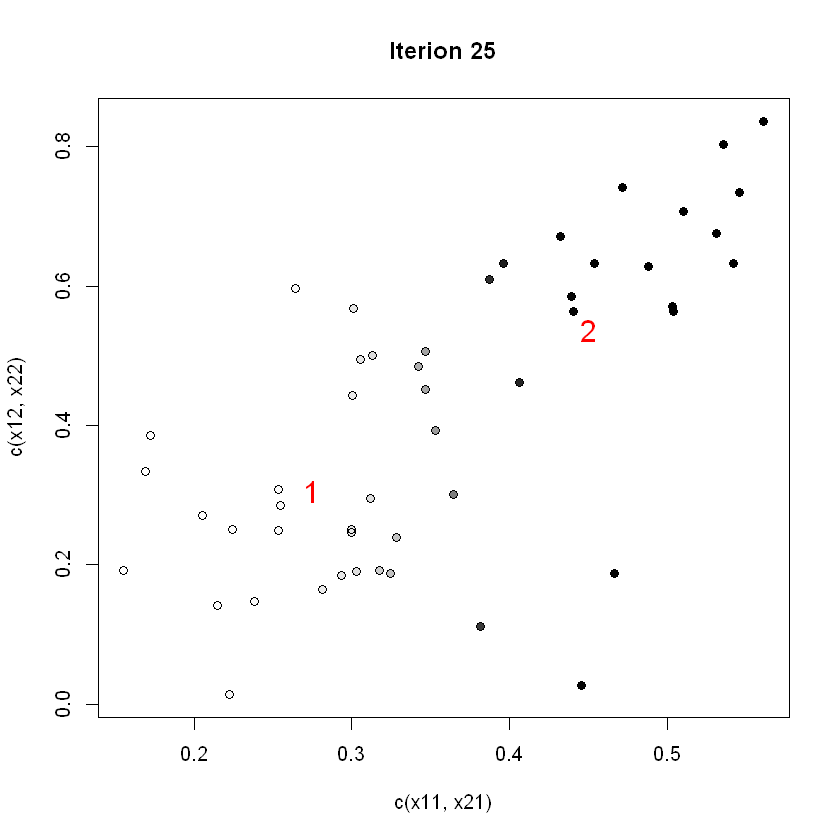

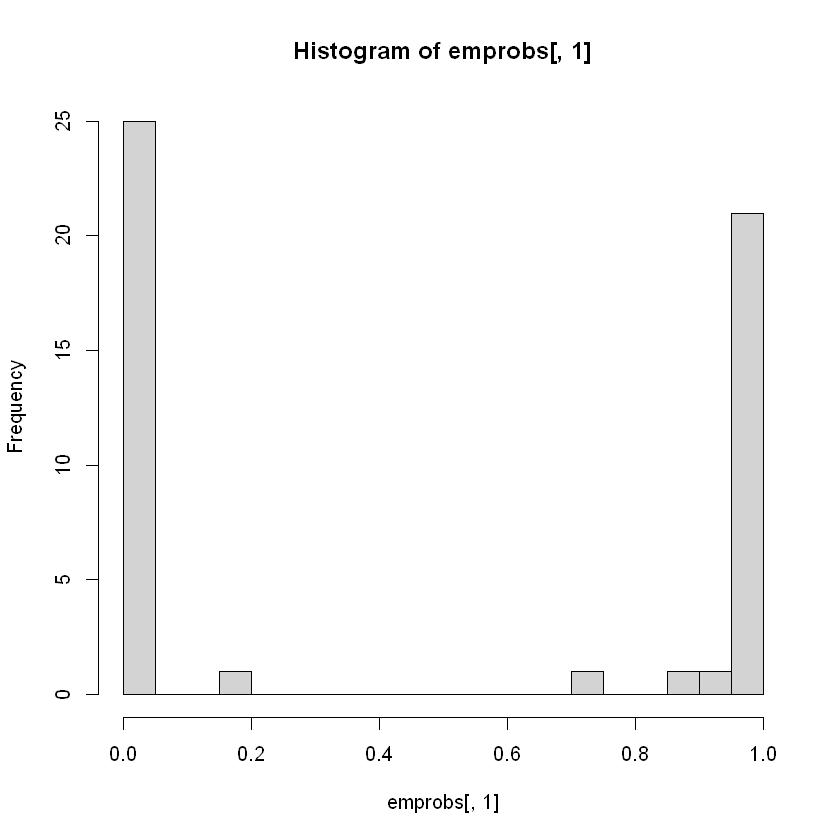

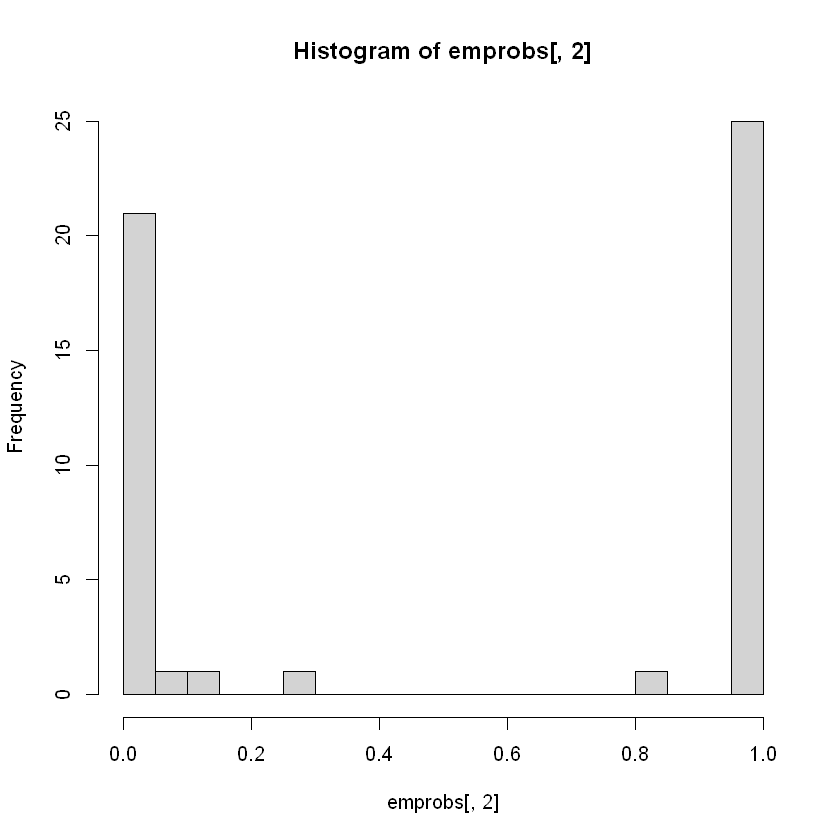

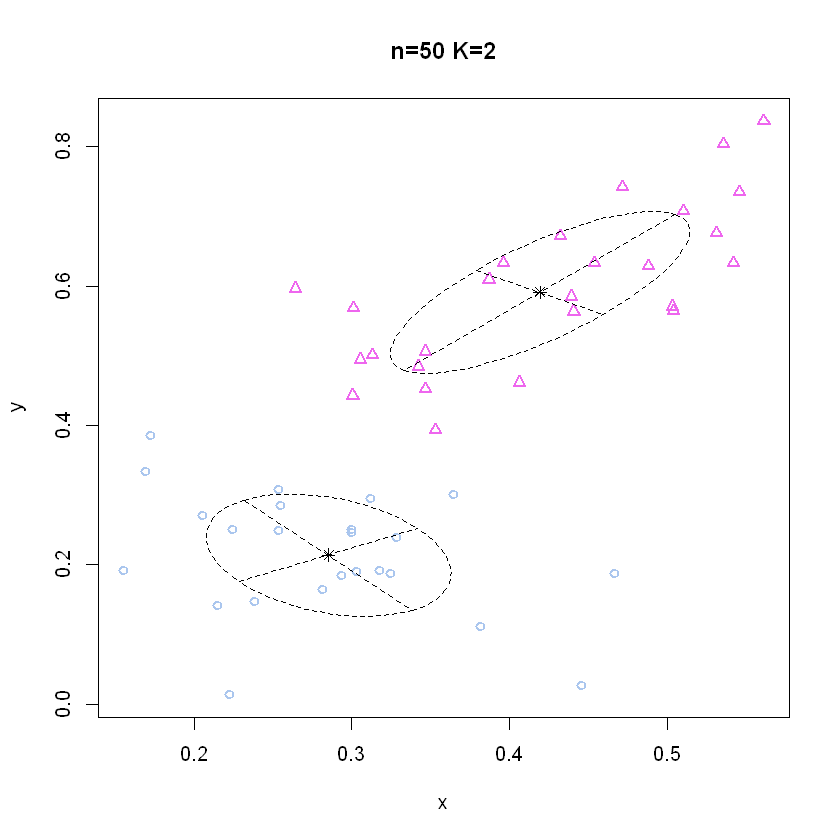

   truth
     1  2
  1 24  0
  2  1 25

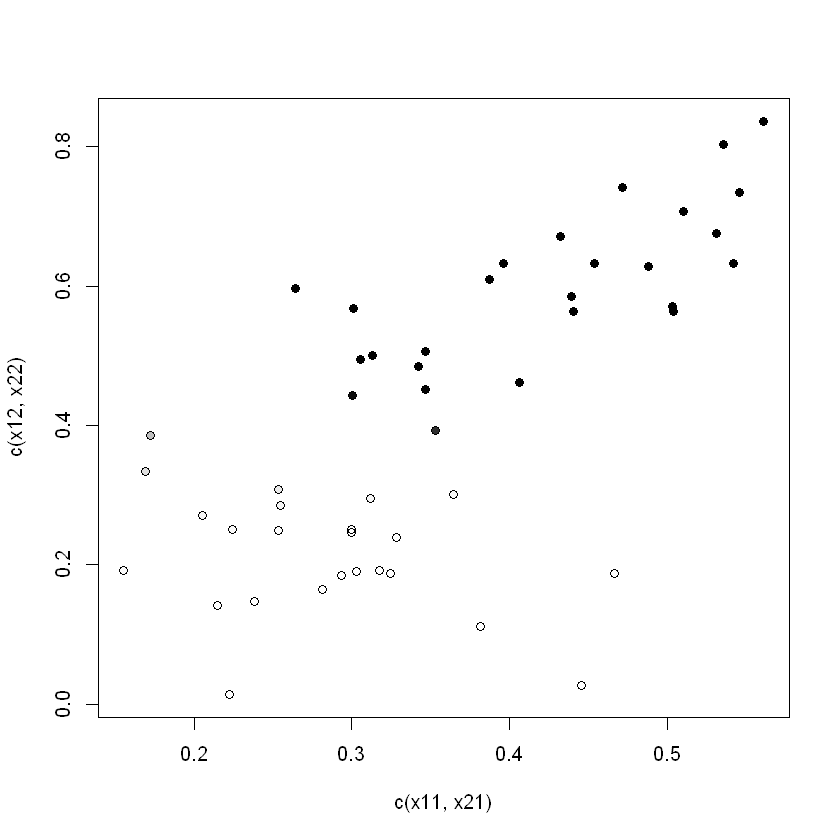

In [3]:
#==============================================================================#
# EM Clustering by Hand                            #
# Machine Learning I - SoSe24                         #
#==============================================================================#
rm(list = ls(all.names = TRUE))


# 00: load packages -----------------------------------------------------------
library("mvtnorm")
library("EMCluster")

# 01: data generation ---------------------------------------------------------

# define the data which contains two clusters 
set.seed(13353) 

# first cluster
x11 <- rnorm(25, 0.3, 0.1)
x12 <- rnorm(25, 0.3, 0.1) - 0.4 * x11

# second cluster
x21 <- rnorm(25, 0.4, 0.1)
x22 <- rnorm(25, 0.4, 0.1) + 0.5 * x21

# cbind into a matrix
Xdata <- cbind(c(x11, x21), c(x12, x22))

# And we know which cluster they were in
truth <- rep(c(1, 2), c(25, 25))

# plot the data
plot(c(x11, x21), c(x12, x22), pch = truth, col = truth)


# 02: Simple kmeans clustering with two clusters -------------------------------

km.out <- kmeans(scale(Xdata), centers = 2, nstart = 20)
plot(Xdata[, 1], Xdata[, 2], col = km.out$cluster, pch=truth)
table(km.out$cluster, truth)

# The triangles on the left side of the upper cluster are wrongly assigned

# 03: EM Clustering ------------------------------------------------------------

# initialise a matrix to contain the cluster allocation probabilities
probs <- matrix(NA, 50, 2)

# Initialise cluster centroids
EMmeans11 <- 0.2  # cluster 1 dimension 1
EMmeans21 <- 0.45 # cluster 2 dimension 1
EMmeans12 <- 0.3  # cluster 1 dimension 2
EMmeans22 <- 0.3  # cluster 2 dimension 2

# Plot the initial centroids 
plot(c(x11, x21), c(x12, x22), pch = 1)
points(EMmeans11, EMmeans12, pch = "1")
points(EMmeans21, EMmeans22, pch = "2")

# Initialise cluster covariances as a the global variance 
# times the identity matrix.
Sigma1 <- cov(Xdata)
Sigma2 <- cov(Xdata)

# 03a: Iteration starts from here ----------------------------------------------

# E step (estimation) -----
# calculate the cluster allocation probabilities

# density in clust 1
tprob1 <- dmvnorm(Xdata, mean = c(EMmeans11, EMmeans12), sigma = Sigma1) 
# density in clust 2
tprob2 <- dmvnorm(Xdata, mean = c(EMmeans21, EMmeans22), sigma = Sigma2) #density in clust 2
# density proportion 
probs[, 1] <- tprob1/(tprob1 + tprob2) 
probs[, 2] <- 1 - probs[, 1]


# Histogram of the probability the element is in clust 1
hist(probs[, 1], breaks=20)
 
 
# M step (MLE) -----
# update the weighted means in each group
EMmeans11 <- weighted.mean(Xdata[, 1], w = probs[, 1])
EMmeans21 <- weighted.mean(Xdata[, 1], w = probs[, 2])
EMmeans12 <- weighted.mean(Xdata[, 2], w = probs[, 1])
EMmeans22 <- weighted.mean(Xdata[, 2], w = probs[, 2])

# update the weighted coovariances in each group
Sigma1 <- cov.wt(Xdata, wt = probs[, 1])$cov
Sigma2 <- cov.wt(Xdata, wt = probs[, 2])$cov

# plot the updated centroids grey points are uncertain
# the darker the color the higher the probability for cluster ???
plot(c(x11, x21), c(x12, x22), pch=16, col=grey(probs[, 1]),
     main = "Iterion 1")
points(c(x11, x21), c(x12, x22), pch=1)
points(EMmeans11, EMmeans12, pch = "1", col = "red", cex = 1.5)
points(EMmeans21, EMmeans22, pch = "2", col = "red", cex = 1.5)



# repeat 25 more iterations
for(i in 1:25){
  
  # E step: 
  # density in clust 1
  tprob1 <- dmvnorm(Xdata, mean = c(EMmeans11, EMmeans12), sigma = Sigma1) 
  # density in clust 2
  tprob2 <- dmvnorm(Xdata, mean = c(EMmeans21, EMmeans22), sigma = Sigma2) #density in clust 2
  # density proportion 
  probs[, 1] <- tprob1/(tprob1 + tprob2) 
  probs[, 2] <- 1 - probs[, 1]

  # M step
  # update the weighted means in each group
  EMmeans11 <- weighted.mean(Xdata[, 1], w = probs[, 1])
  EMmeans21 <- weighted.mean(Xdata[, 1], w = probs[, 2])
  EMmeans12 <- weighted.mean(Xdata[, 2], w = probs[, 1])
  EMmeans22 <- weighted.mean(Xdata[, 2], w = probs[, 2])
  
  # update the weighted coovariances in each group
  Sigma1 <- cov.wt(Xdata, wt = probs[, 1])$cov
  Sigma2 <- cov.wt(Xdata, wt = probs[, 2])$cov
  
  # plot the updated centroids grey points are uncertain
  # the darker the color the higher the probability for cluster ???
  plot(c(x11, x21), c(x12, x22), pch=16, col=grey(probs[, 1]),
       main = paste0("Iterion ", i))
  points(c(x11, x21), c(x12, x22), pch=1)
  points(EMmeans11, EMmeans12, pch = "1", col = "red", cex = 1.5)
  points(EMmeans21, EMmeans22, pch = "2", col = "red", cex = 1.5)
  
}



# 04: EMcluster -Package -------------------------------------------------------

# Now use the emcluster package to do the same
library(EMCluster)
emobj <- init.EM(Xdata, nclass = 2)
emclobj <- emcluster(Xdata, emobj, assign.class = TRUE)
emprobs <- round(e.step(Xdata, emobj = emclobj)$Gamma, 3)

hist(emprobs[,1], breaks=20)
hist(emprobs[,2], breaks=20)
plotem(emclobj, Xdata, lwd=2)


plot(c(x11,x21),c(x12,x22),
     pch=16, col=grey(emprobs[,1]))
points(c(x11,x21),c(x12,x22),pch=1)

# compare the hard clusters with the true cluster values.
table(emclobj$class, truth)

3.3 EM Clustering using the USArrests data


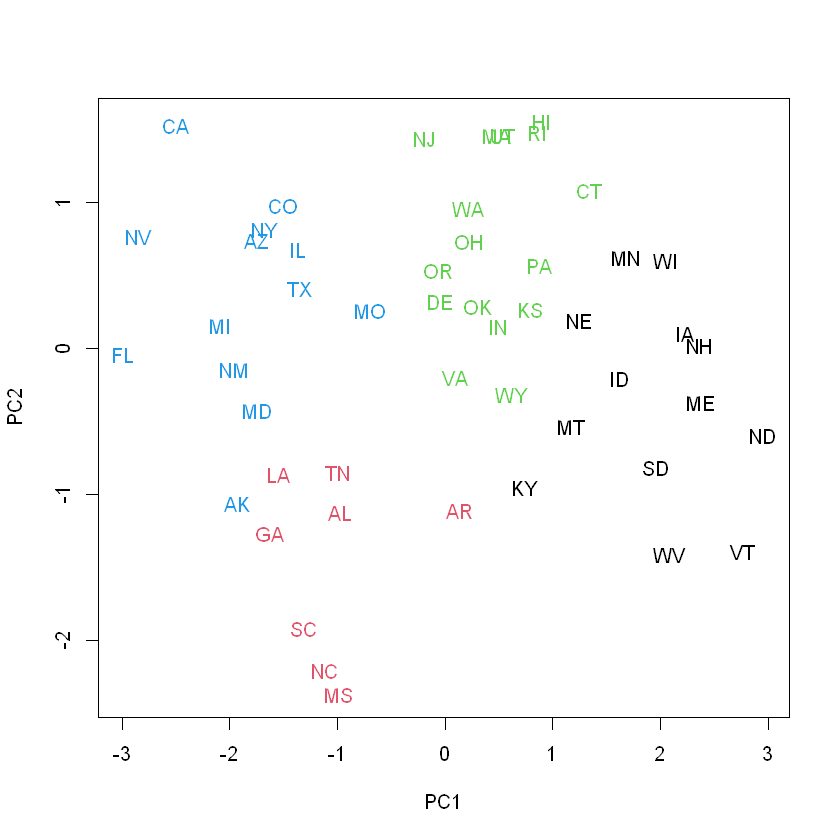

In [4]:
data("USArrests")
USArr_scaled <- scale(USArrests)
km_out <- kmeans(USArr_scaled, centers = 4, nstart = 20)
pca_out <- prcomp(USArr_scaled)
plot(pca_out$x[, 1:2], type = "n")
text(pca_out$x[, 1:2], labels = state.abb, col = km_out$cluster)

In [5]:
library(EMCluster)
em_obj<- init.EM(USArrests, nclass = 4)
em_cl_obj <- emcluster(USArrests, em_obj, assign.class = TRUE)
em_cl_probs <- e.step(USArrests, emobj = em_cl_obj)$Gamma


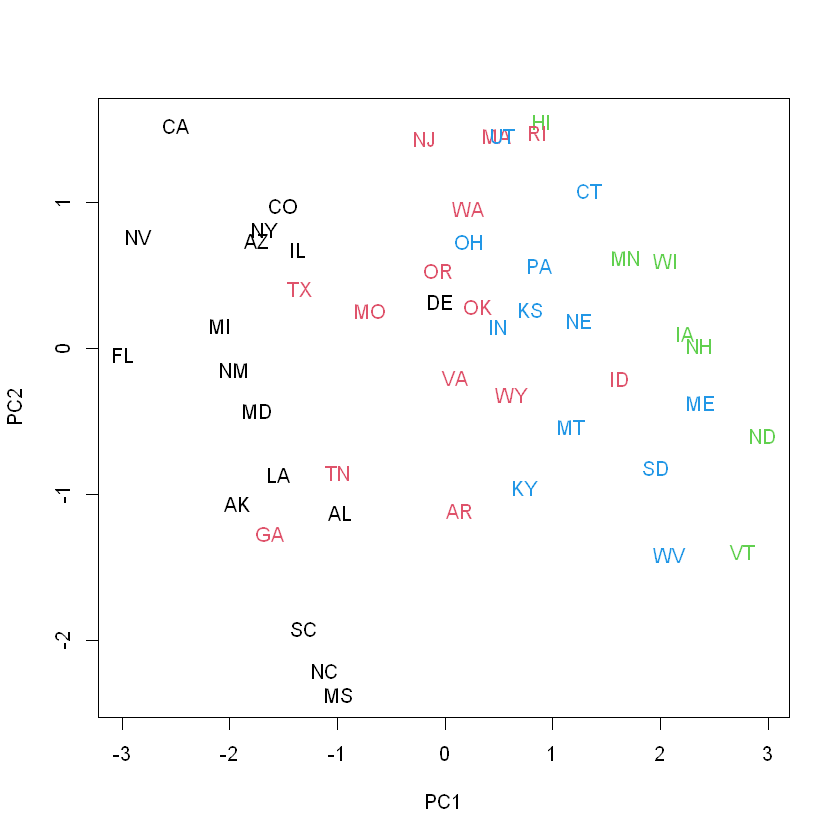

In [6]:
plot(pca_out$x[, 1:2], type = "n")
text(pca_out$x[, 1:2], labels = state.abb, col= em_cl_obj$class)

In [7]:
round(em_cl_probs[km_out$cluster == 1, ], 2)
round(apply(em_cl_probs[km_out$cluster == 1, ], 2, mean), 2)

0,1,0,0
0,0,1,0
0,0,0,1
0,0,0,1
0,0,1,0
0,0,0,1
0,0,0,1
0,0,1,0
0,0,1,0
0,0,0,1
0,0,1,0


[1] 0.00 0.08 0.46 0.46

4 Written Exercises